<a href="https://colab.research.google.com/github/rakshitgupta22/human-AI-text/blob/main/AI_Human_Detector_interpretations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers captum lime bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 124.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.3 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from captum.attr import LayerIntegratedGradients
from captum.attr import LayerGradientXActivation
from captum.attr import visualization as viz
from lime.lime_text import LimeTextExplainer

In [ ]:
#Load the trained model and tokenizer from drive
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/RA/roberta-chatgpt-hc3", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/RA/roberta-chatgpt-hc3-tokenizer")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
from torch.utils.data import TensorDataset, SequentialSampler, DataLoader
import numpy as np

#Function to make predictions
def predict_custom_sent(text, model, tokenizer):
  #tokenizing test set
  encoded_dict = tokenizer.encode_plus(
                            str(text),        #sentence
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens
                            max_length = 256,        #Since we have seen from our analysis that majority of sentences have length less than 300.
                            padding = 'max_length',     # Pad sentences to 256 length  if the length of sentence is less than max_length
                            return_attention_mask = True,   # Create attention mask
                            truncation = True,   # truncate sentences to 256 length  if the length of sentence is greater than max_length
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )

  # bert_input_ids_test,bert_attention_masks_test,labels_test = token_dict_test["Bert"]
  input_ids, attention_masks = encoded_dict["input_ids"], encoded_dict["attention_mask"]
  test_dataset = TensorDataset(input_ids, attention_masks)

  sampler = SequentialSampler(test_dataset)
  prediction_dataloader = DataLoader(test_dataset, sampler=sampler, batch_size=32)

  model.eval()
  predictions = []
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch

    with torch.no_grad():

        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]


    logits = logits.detach().cpu().numpy()

    # Store predictions and true labels
    predictions.append(logits)

  predictions_labels = [item for subitem in predictions for item in subitem]
  predictions_labels = np.argmax(predictions_labels, axis=1).flatten()
  return "ChatGPT" if predictions_labels[0] == 1 else "Human"

In [ ]:
test_sample9 = """Life insurance is a contract between an insured (insurance policy holder) and an insurer , where the insurer promises to pay a designated beneficiary a sum of money (the "benefits") upon the death of the insured person. Depending on the contract, other events such as terminal illness or critical illness may also trigger payment.Protection policies are designed to provide a benefit in the event of specified event, typically a lump sum payment."""
# predict_custom_sent(test_sample9, model, tokenizer)

In [ ]:
test_sample10 = """Let 's say you have a family . Your family has come to rely on your income to pay the bills , like the house payment , the car payment , and even put a little money aside for the kids college . But you decide to be a selfish son of a bitch , and die . Leaving your family without someone to earn an income to pay for the house and that other shit . You family would hate you eternally , and you would be sent to Hell for all of eternity . Life insurance will save you from Hell . Usually you can get the agent to set you a rate for a number of years that he does n't think you will die . Let 's say you are 35 years old . You may get a term life insurance policy for 25 years . Your payout should be at least 5 times your annual income . What does this mean ? The term length sets how long the rate ( amount of money you pay each month ) will be good for ( this case 25 years the insurance company ca n't charge you more for your insurance or cancel your policy . ) Five times your annual salary will ensure that your lazy spouse will have half a decade to stop screwing around a find someone to marry . Whole life will cover your burial , and not a lot more . The good thing about whole life is you can borrow from it when you need . The amount of money you put in every month is a little higher than term , because with whole life , the insurance companies know they will have to pay out on whole life . The advantage to you is that you can build up some interest and withdraw the money when you are too old to spend it anyway ."""
predict_custom_sent(test_sample10, model, tokenizer)

'Human'

In [ ]:
#Loading thr raw dataset and splitting it in train test and validation sets
import pandas as pd
chatgpt_responses = pd.read_csv("/content/drive/MyDrive/RA/chatgpt_responses.tsv", sep="\t", engine='c', names=['ID', 'text'])
human_responses = pd.read_csv("/content/drive/MyDrive/RA/human_responses.tsv", sep="\t", names=['ID', 'text'])

chatgpt_responses['label'] = 1
human_responses['label'] = 0

data = pd.concat([chatgpt_responses[:15000], human_responses[:15000]], axis=0)

from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size = 0.2, stratify = data['label'],random_state=0)
data_valid, data_test = train_test_split(data_test, test_size = 0.5, stratify = data_test['label'], random_state=0)

Predicting labels for 3,000 test sentences...
    DONE.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       1.00      1.00      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



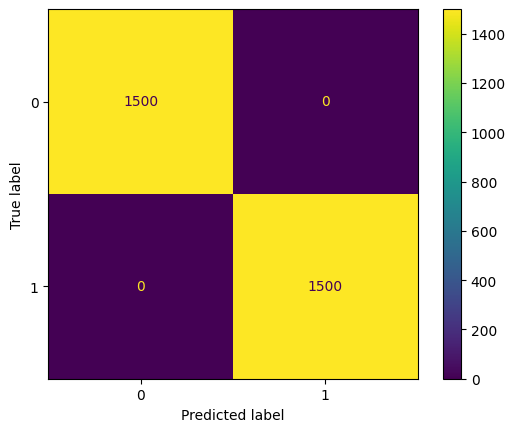

In [ ]:
# Below function performs tokenization process as required by bert and roberta models, for a given dataset
def bert_robert_tokenization(dataset):
  sentences = dataset["text"].values
  labels = dataset["label"].values
  max_length = 256

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  bert_input_ids = []
  bert_attention_masks = []
  roberta_input_ids = []
  roberta_attention_masks = []

  sentence_ids = []
  counter = 0

  # For every sentence...
  for sent in sentences:
      #encode_plus function will encode the sentences as required by model, including tokenization process and mapping token ids

      roberta_encoded_dict = tokenizer.encode_plus(
                          str(sent),        #sentence
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens
                          max_length = 256,        #Since we have seen from our analysis that majority of sentences have length less than 300.
                          padding = 'max_length',     # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,   # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )


      # Add the encoded sentence to the list.
      roberta_input_ids.append(roberta_encoded_dict['input_ids'])
      #roberta_input_ids.append(roberta_encoded_dict['input_ids'])


      # Add attention mask to the list
      roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
      #roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])


      # collecting sentence_ids
      sentence_ids.append(counter)
      counter  = counter + 1



  # Convert the lists into tensors.
  roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
  roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)


  labels = torch.tensor(labels)
  sentence_ids = torch.tensor(sentence_ids)

  return {#"Bert":[bert_input_ids, bert_attention_masks, labels],
          "Roberta":[roberta_input_ids, roberta_attention_masks, labels]
          }

from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

#tokenizing test set
token_dict_test = bert_robert_tokenization(data_test)

# bert_input_ids_test,bert_attention_masks_test,labels_test = token_dict_test["Bert"]
roberta_input_ids_test, roberta_attention_masks_test, labels_test = token_dict_test["Roberta"]

roberta_test_dataset = TensorDataset(roberta_input_ids_test, roberta_attention_masks_test, labels_test)

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
roberta_prediction_sampler = SequentialSampler(roberta_test_dataset)
roberta_prediction_dataloader = DataLoader(roberta_test_dataset, sampler=roberta_prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(roberta_input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in roberta_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():

      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]


  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print (classification_report(predictions_labels, flat_true_labels))
cm_test = confusion_matrix(flat_true_labels, predictions_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()

In [ ]:
data_test.head()

,ID,text,label,predicted_label
10227,3409_H_0,basically calculus is all to do with calcuatin...,0,0
8368,8370_C_0,Karma is a way of measuring how much a user ha...,1,1
79,26_H_1,What I know of my company is that I make much ...,0,0
14132,4710_H_2,If you stand in one place and turn around 360 ...,0,0
3301,3301_C_0,A car's maximum speed is the highest speed tha...,1,1


In [ ]:
data_test['text_words'] = data_test['text'].apply(lambda x: x.split(" "))
data_test['text_len'] = data_test['text_words'].apply(lambda x: len(x))

In [ ]:
#Filtering the input sentences to less than 256 words as the GPU times out on longer sentences.
data_test_filtered = data_test[data_test['text_len'] <= 256].reset_index(drop=True)

In [ ]:
data_test_filtered.head()

,ID,text,label,predicted_label,text_words,text_len
0,8370_C_0,Karma is a way of measuring how much a user ha...,1,1,"[Karma, is, a, way, of, measuring, how, much, ...",123
1,26_H_1,What I know of my company is that I make much ...,0,0,"[What, I, know, of, my, company, is, that, I, ...",159
2,4710_H_2,If you stand in one place and turn around 360 ...,0,0,"[If, you, stand, in, one, place, and, turn, ar...",97
3,3301_C_0,A car's maximum speed is the highest speed tha...,1,1,"[A, car's, maximum, speed, is, the, highest, s...",127
4,647_C_0,Lobotomy is a surgical procedure in which the ...,1,1,"[Lobotomy, is, a, surgical, procedure, in, whi...",128


In [ ]:
#Helper functions for Integrated Gradients Algorithm implementation
def forward_lig(x):
    return model(x)[0]

lig = LayerIntegratedGradients(forward_lig, model.roberta.embeddings)

In [ ]:
def obj(track):
	mx = max(track)
	mn = min(track)

	if abs(mn)>abs(mx):
		return mn
	else:
		return mx

In [ ]:
def combine_words_roberta_minmax(broken,atts):
	formed = []
	i = 0
	at = []
	while i < len(broken):
		j = i+1
		temp = broken[i].split("Ġ")[-1]
		cnt=1
		at.append(atts[i])
		track = [atts[i]]
		formed.append(temp)
		i = j
	assert len(at) == len(formed)
	return formed,torch.Tensor(at)

In [ ]:
#Function to generate attribute scores using the Integrated Gradients Algorithm
"""
x: input
l: label
lig: forward function of model
"""
def get_interpret_ig(x,l,lig):
	inp = torch.LongTensor([tokenizer.encode(x,truncation=True)]).to(device)
	# print("inp",inp.shape)
	label = torch.LongTensor([l]).to(device)
	bsl = torch.LongTensor([0]*inp.size()[1]).unsqueeze(0).to(device)
	# print("bsl",bsl.shape)
	attributions,delta = lig.attribute(inputs=inp,
								  baselines=bsl,
								  n_steps = 50,
								  target = label,
								  return_convergence_delta=True
								  )

	atts = attributions.sum(dim=-1).squeeze(0)
	atts = atts / torch.norm(atts)

	f = tokenizer.convert_ids_to_tokens(tokenizer.encode(x,truncation=True))
	f, atts_list = combine_words_roberta_minmax(f,atts.detach().cpu().numpy().tolist())

	return atts_list,f, atts, inp, delta

In [ ]:
#Sample call made to test the function
attributions, words, atts_tensor, input_ids, delta = get_interpret_ig(test_sample9,1,lig)

In [ ]:
from captum.attr import visualization as viz

In [ ]:
#Function to visualize the attribute scores
def get_viz_data_record(text, true_label):
    attributions, words, atts_tensor, input_ids, delta = get_interpret_ig(text,true_label,lig)
    score_vis = viz.VisualizationDataRecord(
                            word_attributions = attributions,
                            pred_prob = torch.max(torch.softmax(model(input_ids)[0], dim = 0)),
                            pred_class = torch.argmax(model(input_ids)[0]).cpu().numpy(),
                            true_class = true_label,
                            attr_class = text,
                            attr_score = attributions.sum(),
                            raw_input_ids = words,
                            convergence_score = delta)

    return score_vis

In [ ]:
score_viz_records = []
for i in range(4):
    score_viz_records.append(get_viz_data_record(data_test_filtered.iloc[i]['text'], data_test_filtered.iloc[i]['label']))

viz.visualize_text(score_viz_records)

In [ ]:
data_test.iloc[0]

ID                                                          3409_H_0
text               basically calculus is all to do with calcuatin...
label                                                              0
predicted_label                                                    0
Name: 10227, dtype: object

In [ ]:
#Helper functions for LIME
def combine_words_lime_roberta_break(broken):
	formed = []
	i = 0
	while i < len(broken):
		temp = broken[i].split("Ġ")[-1]
		formed.append(temp)
		i = i+1
	return formed

In [ ]:
def calculate_lime(inp):
	labels = []
	for i in inp:
		labels.append(model(torch.LongTensor([tokenizer.encode(i,truncation=True)]).to(device))[0].detach().cpu().numpy()[0])
	return torch.Tensor(labels).cpu().numpy()

In [ ]:
def break_string(x):
	f = tokenizer.tokenize(x)
	return f

def breaker_roberta(x):
	x = x.lower()
	p = combine_words_lime_roberta_break(break_string(x))
	return p

In [ ]:
def get_interpret_lime(inp,l=None,explainer=None):
	exp = explainer.explain_instance(inp, calculate_lime, num_samples=500, num_features=500)
	words = exp.as_list()[:]
	att = []
	for i in exp.as_map():
		att = sorted(exp.as_map()[i])

	att = [i[1] for i in att]
	att = torch.Tensor(att)

	maps = exp.as_map()[1]
	# print(words)
	m = {}
	for i in range(len(maps)):
		m[maps[i][0]] = words[i][0]
	w = [0]*len(m)
	for i in m:
		w[i] = m[i]
	assert len(w) == len(att)
	return att,w

In [ ]:
#Initialize the LIME explainer
explainer = LimeTextExplainer(class_names=[0, 1], split_expression = breaker_roberta)

In [ ]:
#Sample call to test LIME implementation
attributions_lime, words_lime = get_interpret_lime(test_sample9.lower(),1,explainer)

In [ ]:
attr = attributions.tolist()
for i in range(0,len(words)):
  print(words[i], ":", attr[i])

In [ ]:
attributions_human, words_human, atts_tensor_human = get_interpret_ig(test_sample10.lower(),0,lig)

In [ ]:
attr_lime = attributions_lime.tolist()
for i in range(0,len(words_lime)):
  print(words_lime[i], ":", attr_lime[i])

Text(0.5, 1.0, 'Integrated Gradients')

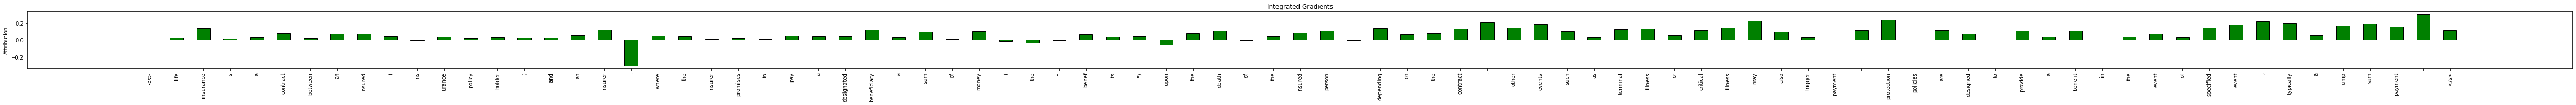

In [ ]:
#Visualizing the attribute scores generated by IG and LIME for a sample sentence
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(len(words),2))
ax.bar(np.arange(len(words)), attributions, width=0.5, linewidth=1, edgecolor='black', color='green')

# Add labels and save plot
ax.set_xticks(np.arange(len(words)))
ax.set_xticklabels(words, rotation = 90)
ax.set_ylabel("Attribution")
ax.set_title("Integrated Gradients")

Text(0.5, 1.0, 'Lime Scores')

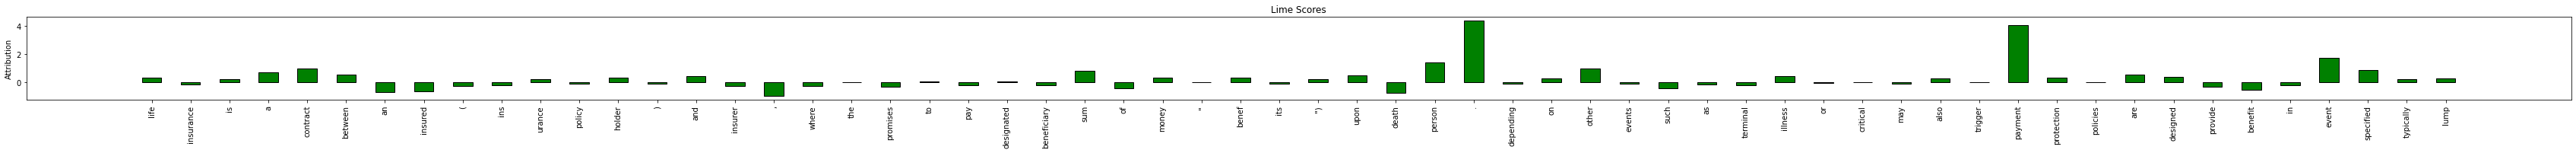

In [ ]:
fig, ax = plt.subplots(figsize=(len(words_lime),2))
ax.bar(np.arange(len(words_lime)), attributions_lime, width=0.5, linewidth=1, edgecolor='black', color='green')

# Add labels and save plot
ax.set_xticks(np.arange(len(words_lime)))
ax.set_xticklabels(words_lime, rotation = 90)
ax.set_ylabel("Attribution")
ax.set_title("Lime Scores")

Text(0.5, 1.0, 'Integrated Gradients')

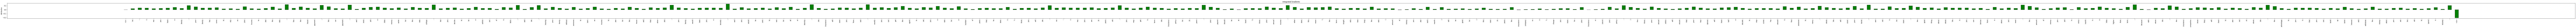

In [ ]:
fig, ax = plt.subplots(figsize=(len(words_human),2))
ax.bar(np.arange(len(words_human)), attributions_human, width=0.5, linewidth=1, edgecolor='black', color='green')

# Add labels and save plot
ax.set_xticks(np.arange(len(words_human)))
ax.set_xticklabels(words_human, rotation = 90)
ax.set_ylabel("Attribution")
ax.set_title("Integrated Gradients")

In [ ]:
#Generating interpretability scores for top 1000 sentences in dataset and taking averages to get a global level interpretation of the model
tokens_col, attr_col = [], []
for idx in data_test_filtered.index[0:1000]:
    print("Getting attribute scores for index:",idx)
    attr, tokens,_,_,_ = get_interpret_ig(data_test_filtered['text'][idx].lower(), data_test_filtered['label'][idx], lig)
    tokens_col.append(tokens)
    attr_col.append(attr.tolist())

# data_test['tokenized_sent'] = tokens_col
# data_test['attributes'] = attr_col

In [ ]:
human_idx = []
chatgpt_idx = []
for idx in data_test_filtered.index[0:1000]:
    if data_test_filtered['predicted_label'][idx] == 1:
        chatgpt_idx.append(idx)
    else:
        human_idx.append(idx)

In [ ]:
attr_avg_list_human = {}
attr_avg_list_chatgpt = {}

for idx in human_idx:
    # print(tokens_col[idx])
    for i in range(len(tokens_col[idx])):
        # print(tokens_col[idx][i])
        if tokens_col[idx][i] in attr_avg_list_human.keys():
            attr_avg_list_human[tokens_col[idx][i]].append(attr_col[idx][i])
        else:
            attr_avg_list_human[tokens_col[idx][i]] = [attr_col[idx][i]]

for token in attr_avg_list_human.keys():
    attr_avg_list_human[token] = np.mean(np.abs(attr_avg_list_human[token]))


for idx in chatgpt_idx:
    for i in range(len(tokens_col[idx])):
        if tokens_col[idx][i] in attr_avg_list_chatgpt.keys():
            attr_avg_list_chatgpt[tokens_col[idx][i]].append(attr_col[idx][i])
        else:
            attr_avg_list_chatgpt[tokens_col[idx][i]] = [attr_col[idx][i]]

for token in attr_avg_list_chatgpt.keys():
    attr_avg_list_chatgpt[token] = np.mean(np.abs(attr_avg_list_chatgpt[token]))

In [ ]:
df_attr_human = pd.DataFrame(list(attr_avg_list_human.items()), columns = ['token', 'attr_score'])
df_attr_human.head()

,token,attr_score
0,<s>,0.000000
1,what,0.116511
2,i,0.076545
3,know,0.095251
4,of,0.026517


In [ ]:
df_attr_chatgpt = pd.DataFrame(list(attr_avg_list_chatgpt.items()), columns = ['token', 'attr_score'])
df_attr_chatgpt.head()

,token,attr_score
0,<s>,0.000000
1,k,0.011298
2,arma,0.042259
3,is,0.019223
4,a,0.018140


In [ ]:
df_attr_human.shape

(6030, 2)

In [ ]:
df_attr_chatgpt.shape

(6874, 2)

In [ ]:
#Saving the attribute scores for future use
df_attr_chatgpt.to_csv("/content/drive/MyDrive/RA/chatgpt_attr_scores_avg_1000_inputs.tsv", sep="\t", index=False)
df_attr_human.to_csv("/content/drive/MyDrive/RA/human_attr_scores_avg_1000_inputs.tsv", sep="\t", index=False)

In [ ]:
import pickle

# open a file in write mode
with open("/content/drive/MyDrive/RA/attr_avg_list_chatgpt.pkl", "wb") as file:
    # serialize the dictionary object and write it to the file
    pickle.dump(attr_avg_list_chatgpt, file)

# open a file in write mode
with open("/content/drive/MyDrive/RA/attr_avg_list_human.pkl", "wb") as file:
    # serialize the dictionary object and write it to the file
    pickle.dump(attr_avg_list_human, file)

In [ ]:
df_attr_chatgpt = pd.read_csv("/content/drive/MyDrive/RA/chatgpt_attr_scores_avg_1000_inputs.tsv", sep="\t")
df_attr_human = pd.read_csv("/content/drive/MyDrive/RA/human_attr_scores_avg_1000_inputs.tsv", sep="\t")

In [ ]:
import pickle

with open("/content/drive/MyDrive/RA/attr_avg_list_chatgpt.pkl", "r") as file:
    # serialize the dictionary object and write it to the file
    attr_avg_list_chatgpt = pickle.load(file)

# open a file in write mode
with open("/content/drive/MyDrive/RA/attr_avg_list_human.pkl", "r") as file:
    # serialize the dictionary object and write it to the file
    attr_avg_list_human = pickle.load(file)

In [ ]:
#Infering the results

In [ ]:
df_attr_human.sort_values(by=['attr_score'], ascending=False)[0:50]

,token,attr_score
4488,expects,0.218619
2621,hitch,0.211402
114,",",0.208756
25,.,0.204679
2414,unhealthy,0.202164
5421,relate,0.200825
2329,beneficial,0.199076
5520,economies,0.193174
4740,hysteria,0.182259
5919,thrust,0.180541


<Axes: xlabel='token'>

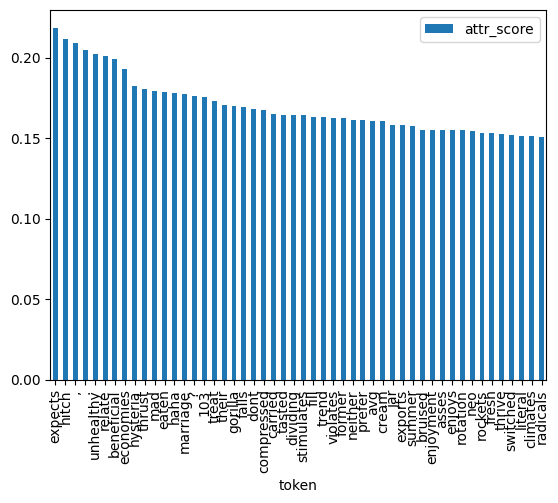

In [ ]:
df_attr_human.sort_values(by=['attr_score'], ascending=False)[0:50].plot(kind = 'bar', x = 'token', y='attr_score')

In [ ]:
data_test_filtered[data_test_filtered['text'].str.contains("expects")]

,ID,text,label,predicted_label,text_words,text_len
590,2859_H_2,It violates everything about what your brain e...,0,0,"[It, violates, everything, about, what, your, ...",12
2095,384_H_0,They usually do n't . It 's used in the media ...,0,0,"[They, usually, do, n't, ., It, 's, used, in, ...",145


In [ ]:
attributions_human, words_human, _,_,_ = get_interpret_ig(data_test_filtered.iloc[590]['text'], data_test_filtered.iloc[590]['label'],lig)

Text(0.5, 1.0, 'Integrated Gradients')

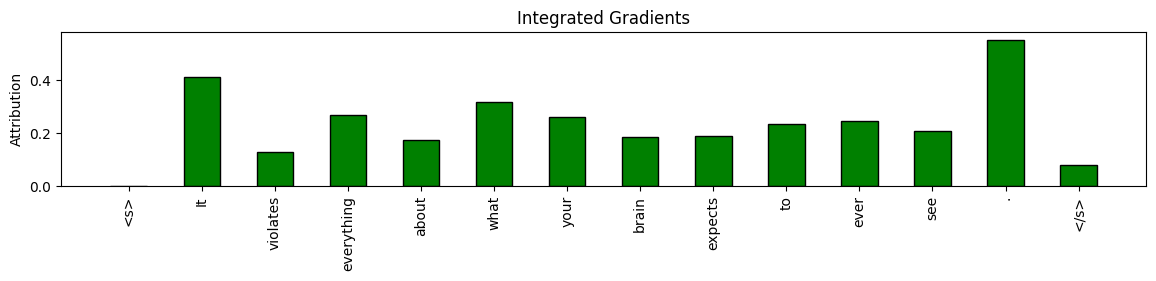

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(len(words_human),2))
ax.bar(np.arange(len(words_human)), attributions_human, width=0.5, linewidth=1, edgecolor='black', color='green')

# Add labels and save plot
ax.set_xticks(np.arange(len(words_human)))
ax.set_xticklabels(words_human, rotation = 90)
ax.set_ylabel("Attribution")
ax.set_title("Integrated Gradients")

In [ ]:
score_viz_records = [get_viz_data_record(data_test_filtered.iloc[590]['text'], data_test_filtered.iloc[590]['label'], data_test_filtered.iloc[590]['predicted_label'])]
viz.visualize_text(score_viz_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (1.00),It violates everything about what your brain expects to ever see .,3.26,#s It violates everything about what your brain expects to ever see . #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (1.00),It violates everything about what your brain expects to ever see .,3.26,#s It violates everything about what your brain expects to ever see . #/s


In [ ]:
df_attr_chatgpt.sort_values(by=['attr_score'], ascending=False)[0:50]

,token,attr_score
4536,reliably,0.562701
2034,versa,0.279441
3031,era,0.255957
74,</s>,0.255213
4854,ancies,0.251306
4858,lifetime,0.226712
2302,feedback,0.223588
2235,intoxicated,0.219218
4574,updates,0.209840
2299,preview,0.192941


<Axes: xlabel='token'>

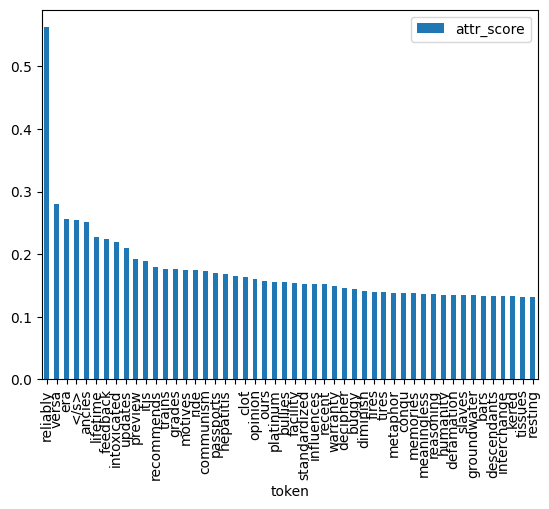

In [ ]:
df_attr_chatgpt.sort_values(by=['attr_score'], ascending=False)[0:50].plot(kind = 'bar', x = 'token', y='attr_score')

In [ ]:
data_test_filtered[data_test_filtered['ID'] == "11367_C_0"]

,ID,text,label,predicted_label,text_words,text_len
57,11367_C_0,That's a good question! Clothing companies mig...,1,1,"[That's, a, good, question!, Clothing, compani...",130


In [ ]:
attributions_gpt, words_gpt, _,_,_ = get_interpret_ig(data_test_filtered.iloc[57]['text'], data_test_filtered.iloc[57]['label'],lig)

In [ ]:
new_attr, new_words = zip(*sorted(zip(attributions_gpt.tolist(), words_gpt), reverse=True))

In [ ]:
attr = new_attr
for i in range(20):
  print(new_words[i], ":", attr[i])

. : 0.4558504819869995
. : 0.41899505257606506
. : 0.3893854022026062
. : 0.3722519874572754
These : 0.19945290684700012
, : 0.18223509192466736
. : 0.16743451356887817
</s> : 0.15735749900341034
Additionally : 0.12917084991931915
If : 0.10905970633029938
It : 0.1084124743938446
, : 0.10035823285579681
other : 0.09153798222541809
decorations : 0.07450336217880249
sizes : 0.06176913157105446
clothes : 0.05257018283009529
sizes : 0.049495402723550797
size : 0.047434452921152115
sizes : 0.046086251735687256
sizes : 0.045086730271577835


In [ ]:
attributions_gpt, words_gpt, _,_,_ = get_interpret_ig(data_test_filtered.iloc[544]['text'], data_test_filtered.iloc[544]['label'],lig)

In [ ]:
new_attr, new_words = zip(*sorted(zip(attributions_gpt.tolist(), words_gpt), reverse=True))

In [ ]:
attr = new_attr
for i in range(20):
  print(new_words[i], ":", attr[i])

. : 0.15821072459220886
, : 0.1353255659341812
. : 0.13390550017356873
. : 0.1331520974636078
, : 0.13133983314037323
, : 0.13081595301628113
. : 0.13040028512477875
, : 0.1296757161617279
, : 0.1296384632587433
, : 0.1291051208972931
. : 0.12860672175884247
, : 0.12806065380573273
, : 0.12786370515823364
, : 0.12680824100971222
, : 0.12161371856927872
. : 0.12127810716629028
, : 0.11918897181749344
, : 0.11879591643810272
, : 0.11875422298908234
. : 0.11783921718597412


Text(0.5, 1.0, 'Integrated Gradients')

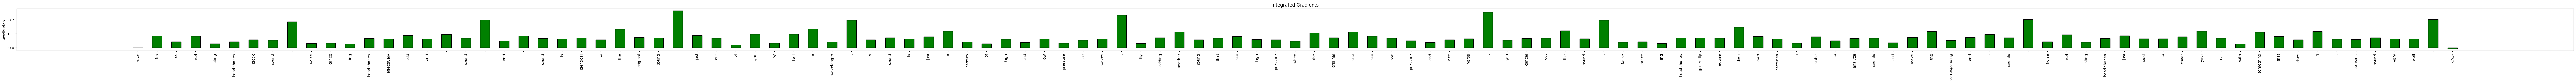

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(len(words_gpt),2))
ax.bar(np.arange(len(words_gpt)), attributions_gpt, width=0.5, linewidth=1, edgecolor='black', color='green')

# Add labels and save plot
ax.set_xticks(np.arange(len(words_gpt)))
ax.set_xticklabels(words_gpt, rotation = 90)
ax.set_ylabel("Attribution")
ax.set_title("Integrated Gradients")

In [ ]:
from random import sample

score_viz_records = []
for i in sample(range(1000), 5):
    score_viz_records.append(get_viz_data_record(data_test_filtered.iloc[i]['text'], data_test_filtered.iloc[i]['label'], data_test_filtered.iloc[i]['predicted_label']))
viz.visualize_text(score_viz_records)

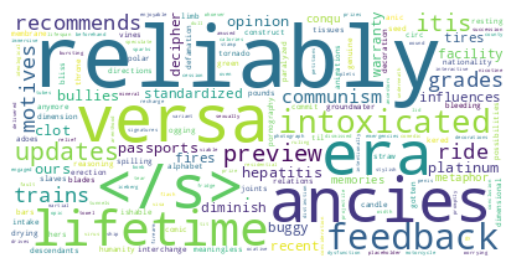

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate the word cloud from the word frequencies
wordcloud = WordCloud(background_color='white').generate_from_frequencies(attr_avg_list_chatgpt)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

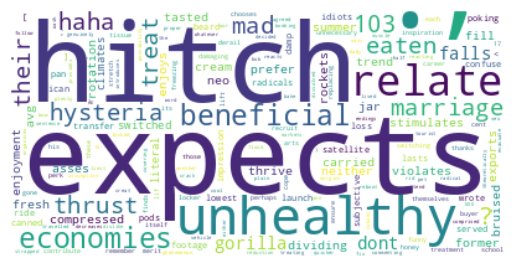

In [ ]:
# Generate the word cloud from the word frequencies
wordcloud = WordCloud(background_color='white').generate_from_frequencies(attr_avg_list_human)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
data_test_filtered[0:1]

,ID,text,label,predicted_label,text_words,text_len
0,8370_C_0,Karma is a way of measuring how much a user ha...,1,1,"[Karma, is, a, way, of, measuring, how, much, ...",123


In [ ]:
for i in range(len(tokens_col[0])):
    print(tokens_col[0][i], ":", attr_col[0][i])

<s> : 0.0
k : -0.039856914430856705
arma : 0.04225931316614151
is : 0.01882172003388405
a : 0.005441509652882814
way : 0.03405459597706795
of : 0.013364860787987709
measuring : 0.0944891944527626
how : 0.007163117174059153
much : 0.01827186718583107
a : -0.01788279600441456
user : 0.06433495879173279
has : -0.0010539233917370439
contributed : 0.025182384997606277
to : -0.019380072131752968
the : -0.033847711980342865
reddit : 0.07990357279777527
community : 0.05131528899073601
. : 0.04077491536736488
when : 0.01683911122381687
other : 0.020331693813204765
users : 0.03023548237979412
up : -0.002404965925961733
vote : 0.03351115062832832
your : -0.003505036002025008
posts : 0.023337645456194878
or : 0.019905371591448784
comments : 0.053600892424583435
, : -0.01468850951641798
you : -0.002903077518567443
receive : 0.040583740919828415
positive : 0.03876887261867523
karma : 0.14452111721038818
. : -0.05407141149044037
when : -0.018005402758717537
they : 0.011297748424112797
down : -0.01043